## Event definition

### Time selection
For the UK, the event of interest is UK February average precipitation. Since we download monthly averages, we do not have to do any preprocessing along the time dimension her. For the Siberian heatwave, we are interested in the March-May average. Therefore we need to take the seasonal average of the monthly timeseries. 

### Spatial selection
From grid to country-averaged timeseries.

In this notebook we explore how to best extract areal averaged precipitation and test this for UK precipitation within SEAS5 and EOBS, as part of our UNSEEN-open [workflow](../Workflow.ipynb). The code is inspired on Matteo De Felice's [blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) -- credits to him!

We create a mask for all 241 countries within [Regionmask](https://regionmask.readthedocs.io/en/stable/#), that has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles). We use the mask to go from gridded precipitation to country-averaged timeseries. We start with UK, number 31 within the country mask. 

#### Import packages

We need the packages regionmask for masking and xesmf for regridding. I cannot install xesmf into the UNSEEN-open environment without breaking my environment, so in this notebook I use a separate 'upscale' environment, as suggested by this [issue](https://github.com/JiaweiZhuang/xESMF/issues/47#issuecomment-582421822). I use the packages esmpy=7.1.0 xesmf=0.2.1 regionmask cartopy matplotlib xarray numpy netcdf4. 

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import regionmask       # Masking
import xesmf as xe      # Regridding

In [3]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks/1.Download'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

#### Load SEAS5 and EOBS


From CDS, we retrieve SEAS5 in notebook [1.2 Retrieve](1.Download/1.2Retrieve.ipynb) and concatenate the retrieved files in notebook [1.3 Merge](1.Download/1.3Merge.ipynb). We create a netcdf file containing the dimensions lat, lon, time (35 years), number (25 ensembles) and leadtime (5 initialization months).

In [5]:
SEAS5 = xr.open_dataset('../UK_example/SEAS5/SEAS5.nc')
SEAS5

<xarray.Dataset>
Dimensions:    (latitude: 11, leadtime: 5, longitude: 14, number: 25, time: 35)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * time       (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime   (leadtime) int64 2 3 4 5 6
Data variables:
    tprate     (leadtime, time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-13 14:49:43 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

And load EOBS netcdf with only February precipitation, resulting in 71 values, one for each year within 1950 - 2020 over the European domain (25N-75N x 40W-75E). 

In [50]:
EOBS = xr.open_dataset('../UK_example/EOBS/EOBS.nc')
EOBS

<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 71)
Coordinates:
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29
Data variables:
    rr         (time, latitude, longitude) float32 ...

#### Masking
Here we load the countries and create a mask for SEAS5 and for EOBS. 

Regionmask has predefined countries from [Natural Earth datasets](http://www.naturalearthdata.com) (shapefiles).

In [7]:
countries = regionmask.defined_regions.natural_earth.countries_50
countries

241 'Natural Earth Countries: 50m' Regions (http://www.naturalearthdata.com)
ZW ZM YE VN VE V VU UZ UY FSM MH MP VI GU AS PR US GS IO SH PN AI FK KY BM VG TC MS JE GG IM GB AE UA UG TM TR TN TT TO TG TL TH TZ TJ TW SYR CH S SW SR SS SD LK E KR ZA SO SL SB SK SLO SG SL SC RS SN SA ST RSM WS VC LC KN RW RUS RO QA P PL PH PE PY PG PA PW PK OM N KP NG NE NI NZ NU CK NL AW CW NP NR NA MZ MA WS ME MN MD MC MX MU MR M ML MV MY MW MG MK L LT FL LY LR LS LB LV LA KG KW KO KI KE KZ J J J I IS PAL IRL IRQ IRN INDO IND IS HU HN HT GY GW GN GT GD GR GH D GE GM GA F PM WF MF BL PF NC TF AI FIN FJ ET EST ER GQ SV EG EC DO DM DJ GL FO DK CZ CN CY CU HR CI CR DRC CG KM CO CN MO HK CL TD CF CV CA CM KH MM BI BF BG BN BR BW BiH BO BT BJ BZ B BY BB BD BH BS AZ A AU IOT HM NF AU ARM AR AG AO AND DZ AL AF SG AQ SX

Now we create the mask for the SEAS5 grid. Only one timestep is needed to create the mask. This mask will lateron be used to mask all the timesteps. 

In [8]:
SEAS5_mask = countries.mask(SEAS5.sel(leadtime=2, number=0, time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')

And create a plot to illustrate what the mask looks like. The mask just indicates for each gridcell what country the gridcell belongs to.

<xarray.DataArray 'region' (latitude: 11, longitude: 14)>
array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  31.,  nan,  31.,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan, 140.,  31.,  31.,  31.,  31.,  31.,  31.,  nan,
         nan,  nan,  nan],
       [ nan, 140., 140., 140., 140.,  nan,  nan,  nan,  nan,  31.,  31.,
         nan,  nan,  nan],
       [ nan,  nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  nan,  nan],
       [ nan, 140., 140., 140.,  nan,  nan,  31.,  31.,  31.,  31.,  31.,
         31.,  31.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  31.,  31.,  31.,  31.,
         31.,  31., 160.],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan, 160.]])
Coordinates:
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0

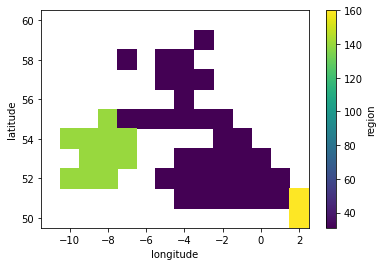

In [9]:
SEAS5_mask
SEAS5_mask.plot()

#### Extract spatial average
And now we can extract the UK averaged precipitation within SEAS5 by using the mask index of the UK: `where(SEAS5_mask == UK_index)`. 
So we need to find the index of one of the 241 abbreviations. In this case for the UK use 'GB'. Additionally, if you can't find a country, use `countries.regions` to get the full names of the countries.
 

In [10]:
countries.abbrevs.index('GB')

31

To select the UK average, we select SEAS5 precipitation (tprate), select the gridcells that are within the UK and take the mean over those gridcells. This results in a dataset of February precipitation for 35 years (1981-2016), with 5 leadtimes and 25 ensemble members.

In [11]:
SEAS5_UK = (SEAS5['tprate']
            .where(SEAS5_mask == 31)
            .mean(dim=['latitude', 'longitude']))
SEAS5_UK

<xarray.DataArray 'tprate' (leadtime: 5, time: 35, number: 25)>
array([[[1.7730116 , 1.9548205 , 3.7803986 , ..., 2.9277864 ,
         1.8929143 , 2.446378  ],
        [3.040877  , 1.8855734 , 4.2009687 , ..., 2.8347836 ,
         4.1132317 , 2.4391398 ],
        [3.556001  , 3.6879914 , 3.184576  , ..., 5.116828  ,
         3.8872097 , 2.6074293 ],
        ...,
        [2.9086895 , 3.7759151 , 4.660708  , ..., 1.6525848 ,
         3.1059399 , 1.6731865 ],
        [2.8330274 , 3.6866314 , 2.634609  , ..., 3.3976977 ,
         4.993076  , 3.6399577 ],
        [2.2500532 , 2.510962  , 3.7602315 , ..., 3.8013346 ,
         1.2315732 , 3.6035924 ]],

       [[1.0868028 , 1.5332695 , 3.2461395 , ..., 1.5274822 ,
         2.7315547 , 1.0240313 ],
        [0.99898285, 2.9119303 , 2.1601522 , ..., 3.3752463 ,
         2.8715765 , 4.393921  ],
        [3.6581304 , 3.5088263 , 2.0143754 , ..., 3.9588785 ,
         3.795881  , 3.179954  ],
        ...,
        [2.5120296 , 3.568533  , 3.4690757 , ..., 2.6206532 ,
         3.953479  , 3.789593  ],
        [1.9866585 , 3.670435  , 2.7552466 , ..., 3.5482445 ,
         1.9896345 , 3.9373026 ],
        [1.9513754 , 2.0166924 , 2.9413762 , ..., 3.3549297 ,
         3.0631557 , 1.915903  ]],

       [[2.0119116 , 2.4435556 , 1.3927166 , ..., 1.8064059 ,
         1.8338976 , 2.4649143 ],
        [2.62523   , 3.6218376 , 3.003645  , ..., 3.3206403 ,
         2.5519    , 3.110555  ],
        [4.071685  , 2.6880858 , 3.8181992 , ..., 1.9033648 ,
         1.8840973 , 4.449085  ],
        ...,
        [2.8379328 , 2.6923704 , 1.82504   , ..., 2.8684394 ,
         3.1954165 , 3.445909  ],
        [2.072118  , 2.0628428 , 2.8790975 , ..., 2.697285  ,
         3.3291562 , 2.9145727 ],
        [3.535856  , 3.6515677 , 2.1052096 , ..., 3.2938933 ,
         3.1968002 , 2.2115657 ]],

       [[2.9105136 , 3.6938024 , 1.1343408 , ..., 1.1984391 ,
         2.9722617 , 2.1267796 ],
        [4.02007   , 1.8249133 , 3.099     , ..., 3.4654658 ,
         2.7237208 , 3.5907636 ],
        [3.1248841 , 2.219241  , 3.6903172 , ..., 0.8401702 ,
         4.017805  , 3.476175  ],
        ...,
        [2.8703861 , 5.5576715 , 1.7174771 , ..., 2.1288645 ,
         1.8581603 , 2.2952495 ],
        [4.179039  , 3.737323  , 2.880745  , ..., 1.9207952 ,
         0.6607291 , 2.8571692 ],
        [1.5515772 , 3.0461147 , 2.0624359 , ..., 2.5376263 ,
         4.744201  , 2.0716472 ]],

       [[3.1285267 , 3.269652  , 2.5995293 , ..., 4.347241  ,
         1.3022097 , 1.4634563 ],
        [2.262867  , 3.3503478 , 2.4287066 , ..., 2.593644  ,
         4.251352  , 3.1974325 ],
        [4.0569496 , 2.156282  , 1.781804  , ..., 4.4861846 ,
         1.8805121 , 4.268968  ],
        ...,
        [1.843329  , 3.1374288 , 2.516779  , ..., 1.3068637 ,
         2.4419744 , 2.2696178 ],
        [4.635685  , 4.429196  , 2.4575038 , ..., 4.441483  ,
         1.3038206 , 2.6521633 ],
        [3.1435733 , 2.614458  , 2.1784708 , ..., 3.662669  ,
         1.6688719 , 1.9709551 ]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number    (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime  (leadtime) int64 2 3 4 5 6

However, xarray does not take into account the area of the gridcells in taking the average. Therefore, we have to calculate the [area-weighted mean](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) of the gridcells. To calculate the area of each gridcell, I use cdo `cdo gridarea infile outfile`. Here I load the generated file:

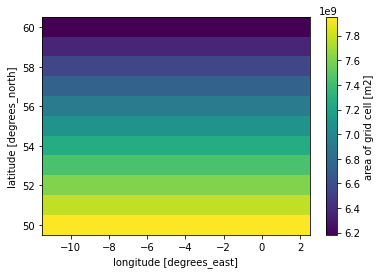

In [12]:
Gridarea_SEAS5 = xr.open_dataset('../UK_example/Gridarea_SEAS5.nc')
Gridarea_SEAS5['cell_area'].plot()

In [13]:
SEAS5_UK_weighted = (SEAS5['tprate']
                  .where(SEAS5_mask == 31)
                  .weighted(Gridarea_SEAS5['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
SEAS5_UK_weighted

<xarray.DataArray (leadtime: 5, time: 35, number: 25)>
array([[[1.74715784, 1.91625164, 3.74246331, ..., 2.9025497 ,
         1.87161458, 2.42337871],
        [3.01557164, 1.86355946, 4.23964218, ..., 2.82348107,
         4.08311346, 2.45320866],
        [3.45037457, 3.67373672, 3.19124952, ..., 5.10772697,
         3.83928173, 2.59254324],
        ...,
        [2.91576568, 3.76689869, 4.64815469, ..., 1.61583385,
         3.07634248, 1.633837  ],
        [2.8217756 , 3.61588493, 2.61442489, ..., 3.36894025,
         5.01010622, 3.58215465],
        [2.21954162, 2.46237273, 3.71758684, ..., 3.72850729,
         1.21044478, 3.5506569 ]],

       [[1.08925258, 1.502868  , 3.23383862, ..., 1.49745391,
         2.74434639, 0.98857514],
        [0.96385251, 2.9144073 , 2.14176199, ..., 3.39404417,
         2.837949  , 4.39105086],
        [3.64189637, 3.44186084, 1.96817031, ..., 3.90560029,
         3.78419096, 3.13070979],
        ...,
        [2.46681904, 3.55272741, 3.41184678, ..., 2.58295751,
         3.84194729, 3.71967185],
        [1.96088291, 3.64719353, 2.73561159, ..., 3.56311814,
         2.00379361, 3.89548019],
        [1.89263296, 1.99179138, 2.91457733, ..., 3.37011609,
         3.05092884, 1.89736692]],

       [[1.94362083, 2.4160058 , 1.36431312, ..., 1.78378666,
         1.82209387, 2.42526171],
        [2.57294707, 3.55756557, 2.96458594, ..., 3.26071746,
         2.60226357, 3.13573254],
        [4.13926899, 2.61380816, 3.76440713, ..., 1.87333769,
         1.82042494, 4.46818308],
        ...,
        [2.81221309, 2.69631474, 1.80062933, ..., 2.86429728,
         3.13303958, 3.44787769],
        [2.07369663, 2.03958281, 2.81885547, ..., 2.65322161,
         3.32297921, 2.83923239],
        [3.49884241, 3.63866711, 2.03510114, ..., 3.24500072,
         3.15147085, 2.16834782]],

       [[2.83876303, 3.61651907, 1.0950032 , ..., 1.17176117,
         2.91180608, 2.1047135 ],
        [3.95351432, 1.78778573, 3.08959013, ..., 3.43481603,
         2.72829325, 3.6158294 ],
        [3.13152664, 2.19419128, 3.64975772, ..., 0.83938823,
         4.01702257, 3.46619512],
        ...,
        [2.90135673, 5.59148292, 1.70016201, ..., 2.08532097,
         1.84797942, 2.23519466],
        [4.19777172, 3.74702108, 2.8748067 , ..., 1.88071816,
         0.62889528, 2.79973163],
        [1.51194718, 3.07317605, 2.05956574, ..., 2.53950207,
         4.70096128, 2.04542173]],

       [[3.15063505, 3.23490175, 2.60923731, ..., 4.27225421,
         1.29816875, 1.42799228],
        [2.21017692, 3.32458317, 2.3819878 , ..., 2.53619218,
         4.24655687, 3.21280586],
        [4.07655988, 2.07606666, 1.75961194, ..., 4.47653645,
         1.81676988, 4.21655002],
        ...,
        [1.82563235, 3.10218576, 2.46347745, ..., 1.28711195,
         2.36333743, 2.26540939],
        [4.63821163, 4.43540009, 2.37741808, ..., 4.44346938,
         1.27125796, 2.63467098],
        [3.12914205, 2.58186504, 2.11029128, ..., 3.6635387 ,
         1.68374372, 1.9288108 ]]])
Coordinates:
  * time      (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number    (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * leadtime  (leadtime) int64 2 3 4 5 6

What is the difference between the weighted and non-weighted average?

I plot the UK average for ensemble member 0 and leadtime 2

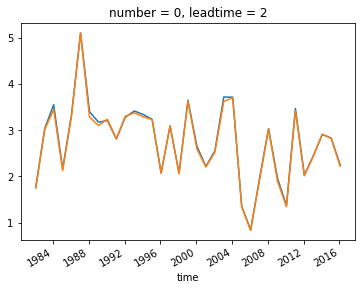

In [14]:
SEAS5_UK.sel(leadtime=2,number=0).plot()
SEAS5_UK_weighted.sel(leadtime=2,number=0).plot()


And a scatter plot of all ensemble members, leadtimes and years also shows little influence

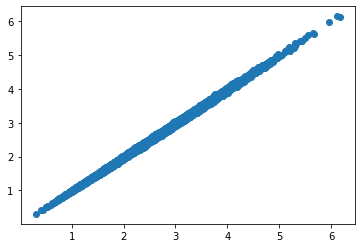

In [15]:
plt.scatter(SEAS5_UK.values.flatten(),SEAS5_UK_weighted.values.flatten())

### EOBS
Same for EOBS. Because this is a larger domain on higher resolution, there are more countries and they look more realistic.

<xarray.DataArray 'region' (latitude: 201, longitude: 464)>
array([[ nan,  nan,  nan, ..., 144., 144., 144.],
       [ nan,  nan,  nan, ..., 144., 144., 144.],
       [ nan,  nan,  nan, ..., 144., 144., 144.],
       ...,
       [181., 181., 181., ...,  nan,  nan,  nan],
       [181., 181., 181., ...,  nan,  nan,  nan],
       [181., 181., 181., ...,  nan,  nan,  nan]])
Coordinates:
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38

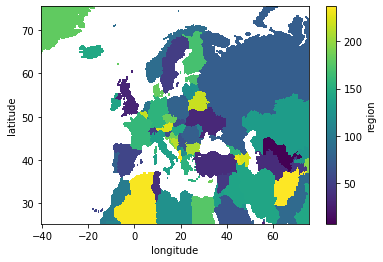

In [52]:
EOBS_mask = countries.mask(EOBS.sel(time='1982'),
                            lon_name='longitude',
                            lat_name='latitude')
EOBS_mask.plot()
EOBS_mask

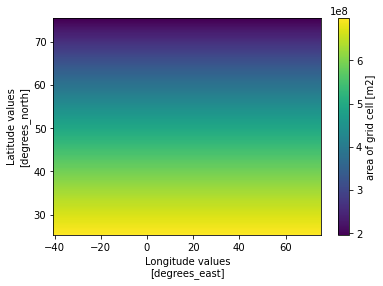

In [53]:
Gridarea_EOBS = xr.open_dataset('../UK_example/Gridarea_EOBS.nc')
Gridarea_EOBS['cell_area'].plot()

<xarray.DataArray (time: 71)>
array([4.0112636 , 3.19827003, 1.11268281, 1.61090816, 2.69306677,
       2.31978493, 0.98650601, 2.63477555, 3.63657055, 0.52167151,
       2.50233819, 2.93969127, 2.06443877, 0.99136675, 1.01560624,
       0.6154935 , 3.93636015, 3.39010865, 1.53137533, 2.15598489,
       3.32269875, 1.78223544, 2.45083221, 2.03587884, 3.3849171 ,
       1.08231163, 1.76152991, 4.20162284, 2.66144679, 1.6568065 ,
       2.91595009, 2.0847285 , 2.17290317, 1.39570346, 2.22253168,
       1.05645274, 0.45730501, 2.02864268, 2.73456517, 4.08896735,
       6.21272081, 2.17751273, 2.52523671, 0.85118189, 2.77141892,
       4.3647128 , 3.00077761, 5.26563969, 2.21997571, 2.63596739,
       4.05858217, 3.15371361, 5.65114533, 1.43401958, 1.96796786,
       2.000555  , 1.87548527, 3.55486921, 2.31611654, 1.74042428,
       2.21678709, 3.55429198, 1.4882801 , 1.77628824, 5.3601659 ,
       2.39871296, 3.39117348, 2.92421785, 1.5737706 , 1.85412429,
       4.91373273])
Coordinates:
  * time     (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2020-02-29

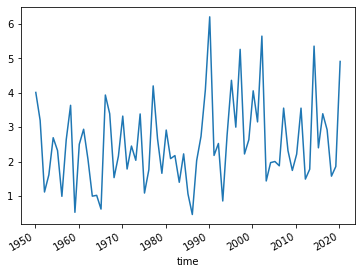

In [54]:
EOBS_UK_weighted = (EOBS['rr']
                  .where(EOBS_mask == 31)
                  .weighted(Gridarea_EOBS['cell_area']) 
                  .mean(dim=['latitude', 'longitude'])
                 )
EOBS_UK_weighted
EOBS_UK_weighted.plot()

#### Save the UK weighted average datasets


In [55]:
SEAS5_UK_weighted.to_netcdf('Data/SEAS5_UK_weighted.nc')
EOBS_UK_weighted.to_netcdf('Data/EOBS_UK_weighted.nc') ## save as netcdf
EOBS_UK_weighted.to_pandas().to_csv('Data/EOBS_UK_weighted.csv') ## and save as csv. 

In [59]:
SEAS5_UK_weighted.close()
EOBS_UK_weighted.close()

#### Illustrate the SEAS5 and EOBS masks for the UK

Here I plot the masked mean SEAS5 and EOBS precipitation. EOBS is averaged over 71 years, SEAS5 is averaged over years, leadtime and ensemble members.  

/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/soge-home/users/cenv0732/.conda/envs/upscale/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

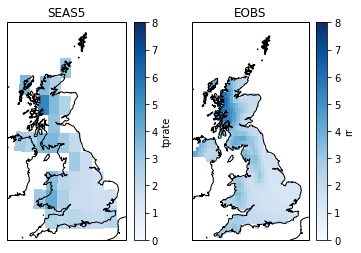

In [57]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].where(SEAS5_mask == 31).mean(
    dim=['time', 'leadtime', 'number']).plot(
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[0])

EOBS['rr'].where(EOBS_mask == 31).mean(dim='time').plot(
    transform=ccrs.PlateCarree(), 
    vmin=0,
    vmax=8,
    cmap=plt.cm.Blues,
    ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='10m')

axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

#### Illustrate the SEAS5 and EOBS UK average

And the area-weighted average UK precipitation for SEAS5 and EOBS I plot here. For SEAS5 I plot the range, both min/max and the 2.5/97.5 % percentile of all ensemble members and leadtimes for each year.  

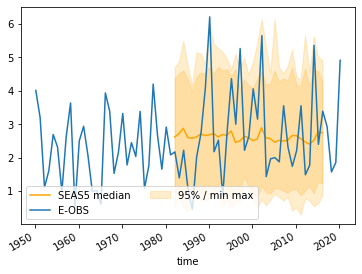

In [58]:
ax = plt.axes()

Quantiles = SEAS5_UK_weighted.quantile([0,2.5/100, 0.5, 97.5/100,1], dim=['number','leadtime'])
ax.plot(Quantiles.time, Quantiles.sel(quantile=0.5), color='orange',label = 'SEAS5 median')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='orange', alpha=0.2,label = '95% / min max')
ax.fill_between(Quantiles.time.values, Quantiles.sel(quantile=0), Quantiles.sel(quantile=1), color='orange', alpha=0.2)

EOBS_UK_weighted.plot(ax=ax,x='time',label = 'E-OBS')

# Quantiles_EOBS = EOBS['rr'].where(EOBS_mask == 143).mean(dim = ['latitude','longitude']).quantile([2.5/100, 0.5, 97.5/100], dim=['time'])#.plot()
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=0.5).values,71), color='blue',linestyle = '--',linewidth = 1)
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=2.5/100).values,71), color='blue',linestyle = '--',linewidth = 1)
# ax.plot(EOBS.time, np.repeat(Quantiles_EOBS.sel(quantile=97.5/100).values,71), color='blue',linestyle = '--',linewidth = 1)

plt.legend(loc = 'lower left', ncol=2 )#loc = (0.1, 0) upper left


### Potential improvements

There are many different sources and methods available for extracting areal-averages from shapefiles. Here I have used shapely / masking in xarray. Something that lacks with this method is the weighted extraction from a shapefile, that is more precise on the boundaries. In R, raster:extract can use the percentage of the area that falls within the country for each grid cell to use as weight in averaging. For more information on this method, see the EGU 2018 course:    https://github.com/hydrosoc/rhydro_EGU18/blob/master/netCDF.pdf. For SEAS5, with its coarse resolution, this might make a difference. However, for it's speed and reproducibility, we have chosen to stick to xarray. 

We have used xarray where you can apply weights yourself to a dataset and then calculate the weighted mean. Sources I have used: [xarray weighted reductions](http://xarray.pydata.org/en/stable/computation.html#weighted-array-reductions) [Matteo's blog](http://www.matteodefelice.name/post/aggregating-gridded-data/) [regionmask package](https://regionmask.readthedocs.io/en/stable/#) [Arctic weighted average example](https://nordicesmhub.github.io/NEGI-Abisko-2019/training/Example_model_global_arctic_average.html) and [area weighted temperature example](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html).

Instead of xarray, the areal weighing can be done in iris: https://www.wemcouncil.org/wp/wemc-tech-blog-4-5-calculating-nuts2-regional-averages-with-land-sea-mask/. It still doesn't solve the problem with country borders. Since I don't know iris and have been working in xarray, I have not further explored that method. 

Two options we could still explore to improve the extraction:

1. Do the extraction in R and compare it to the current xarray method. 
2. Upscale EOBS to the SEAS5 grid and then mask: We could regrid EOBS to the SEAS5 grid and then select the same gridcells for both datasets. The country outline would not be perfect, but the masks would be the same so the comparison would be fair. I think this method is most commonly applied in climate science, where you regrid all your xx datasets to the same grid so you can compare them. Pro: pragmatic. Con: not a perfect country definition. I explore this in [1.5Upscale] 
Source: This pretty [awesome colab notebook](https://colab.research.google.com/drive/1wWHz_SMCHNuos5fxWRUJTcB6wqkTJQCR#scrollTo=B8PyoC1vXvd-) on seasonal forecasting regrids seasonal forecasts and reanalysis on the same grid before calculating skill scores 
